# Imports

In [31]:
import pandas as pd
import numpy as np
import openslide
import os
from deephistopath.wsi import slide, tiles
from deephistopath.wsi import filter as filter_

# Run the following in command line to load up deepzoom_multiserver to view slides
# python3 deepzoom_multiserver.py -Q 100 ~/ga-dsi-11/CAPSTONE/data/manifest_db/ 

# Make Our Panneled DF

In [7]:
metadata_df = pd.read_json('../data/metadata.cart.2020-06-01.json')
metadata_df.head(1)

,data_format,file_id,data_type,file_name,state,experimental_strategy,md5sum,data_category,access,associated_entities,submitter_id,file_size
0,SVS,5df8c657-36b5-410e-a116-cb1f4db29ec7,Slide Image,TCGA-HT-7882-01Z-00-DX4.8B139B5B-567F-4810-A03...,released,Diagnostic Slide,c0e80354a9364a9ab0f31e6c5f51a248,Biospecimen,open,[{'case_id': '912d6455-0a50-4fde-b785-f6c09b00...,TCGA-HT-7882-01Z-00-DX4_slide_image,561683973


In [8]:
# Unpacking associated_entities Dictionary:
for key in metadata_df['associated_entities'][0][0].keys():
    metadata_df[key] = [value[0][key] for value in metadata_df['associated_entities']]

metadata_df.head()

,data_format,file_id,data_type,file_name,state,experimental_strategy,md5sum,data_category,access,associated_entities,submitter_id,file_size,case_id,entity_submitter_id,entity_id,entity_type
0,SVS,5df8c657-36b5-410e-a116-cb1f4db29ec7,Slide Image,TCGA-HT-7882-01Z-00-DX4.8B139B5B-567F-4810-A03...,released,Diagnostic Slide,c0e80354a9364a9ab0f31e6c5f51a248,Biospecimen,open,[{'case_id': '912d6455-0a50-4fde-b785-f6c09b00...,TCGA-HT-7882-01Z-00-DX4_slide_image,561683973,912d6455-0a50-4fde-b785-f6c09b00b7e4,TCGA-HT-7882-01Z-00-DX4,14d2d3db-28e2-4bd7-b5a8-e1074d50d3b8,slide
1,SVS,a710baaa-cfce-470b-ba93-b7a2a69f4de1,Slide Image,TCGA-HT-7482-01Z-00-DX4.5B6C52B2-6DE5-46CC-B8C...,released,Diagnostic Slide,6e72698613fbc225bd18ea7b1ade9a0b,Biospecimen,open,[{'case_id': '448d3e3b-622c-4e79-bb1d-b5f2e929...,TCGA-HT-7482-01Z-00-DX4_slide_image,126657109,448d3e3b-622c-4e79-bb1d-b5f2e92970e8,TCGA-HT-7482-01Z-00-DX4,0d8eda9f-377b-4f0b-a47a-beb2611ab03d,slide
2,SVS,3adc47cf-8b21-4b2b-9684-534451e91322,Slide Image,TCGA-DH-A66B-01Z-00-DX1.8669A577-0481-4C15-B4C...,released,Diagnostic Slide,a26117dc26f87c24dfad0e3a3d5b9bdc,Biospecimen,open,[{'case_id': 'cb1e9916-c03f-405a-a797-15823df0...,TCGA-DH-A66B-01Z-00-DX1_slide_image,1300303345,cb1e9916-c03f-405a-a797-15823df09c8e,TCGA-DH-A66B-01Z-00-DX1,408f0a8c-d873-43a8-b5b7-749f3149ccbd,slide
3,SVS,5a6aa6a1-556c-4481-ac06-3f2feb853296,Slide Image,TCGA-DB-A64Q-01Z-00-DX1.CD3937C2-015A-490D-B6A...,released,Diagnostic Slide,65a1f745caab665311d1bb5d7d53dcc4,Biospecimen,open,[{'case_id': '887def39-e212-490d-8849-2bc932fc...,TCGA-DB-A64Q-01Z-00-DX1_slide_image,1789132612,887def39-e212-490d-8849-2bc932fceff0,TCGA-DB-A64Q-01Z-00-DX1,9bb20abd-0256-45f3-ac18-c1ab73044f31,slide
4,SVS,9ad09160-2a74-4307-ad23-97aec076aa2d,Slide Image,TCGA-R8-A6MK-01Z-00-DXB.F02C56E8-9793-4272-B14...,released,Diagnostic Slide,a22a4a3fb637fb48a6c588f2157b724b,Biospecimen,open,[{'case_id': '65836b59-b469-4b89-adf5-e65735e4...,TCGA-R8-A6MK-01Z-00-DXB_slide_image,2156870006,65836b59-b469-4b89-adf5-e65735e494f5,TCGA-R8-A6MK-01Z-00-DXB,b930e2d7-b22d-4fd3-a856-a8a7d1af0748,slide


In [9]:
# Reload Data and start fresh. 
clinical_df = pd.read_json('../data/clinical.cart.2020-06-01.json')
clinical_df.dropna(inplace=True) # drop row 827 with no info
clinical_df.head(1)

,exposures,demographic,diagnoses,case_id
0,"[{'created_datetime': None, 'cigarettes_per_da...","{'ethnicity': 'not reported', 'year_of_death':...","[{'primary_diagnosis': 'Mixed glioma', 'create...",887def39-e212-490d-8849-2bc932fceff0


In [10]:
# Unpacking Dictionaries:
for col in ['exposures','diagnoses']:
#     print('****',col)
    for key in clinical_df[col][0][0].keys():
        clinical_df[f'{col}_{key}'] = [value[0][key] for value in clinical_df[col]]

In [11]:
# Demographic loaded in not as a list. So we have one less 'layer' to unpack
for key in clinical_df['demographic'][0].keys():
    for i , value in enumerate(clinical_df['demographic']):
        try:
            clinical_df[f'demographic_{key}'] = value[key]
        except:
            clinical_df[f'demographic_{key}'] = np.NaN
            print(f'Encountered Missing value at {key} index {i}')

In [12]:
clinical_df['diagnoses_primary_diagnosis'].value_counts()

Astrocytoma, anaplastic          4
Mixed glioma                     3
Oligodendroglioma, anaplastic    2
Oligodendroglioma, NOS           1
Name: diagnoses_primary_diagnosis, dtype: int64

In [13]:
clinical_df.shape

(10, 54)

In [14]:
metadata_df.shape

(10, 16)

In [15]:
df = metadata_df.merge(clinical_df, left_on = 'case_id', right_on = 'case_id')

In [16]:
df.shape

(10, 69)

In [17]:
# df.info()

In [18]:
classification_df = pd.DataFrame(df[['case_id', # case id
                            'file_id', # name of folder created with file in it
                            'file_name', # actual name of file
                            'diagnoses_primary_diagnosis' # 
                             ]])
classification_df

,case_id,file_id,file_name,diagnoses_primary_diagnosis
0,912d6455-0a50-4fde-b785-f6c09b00b7e4,5df8c657-36b5-410e-a116-cb1f4db29ec7,TCGA-HT-7882-01Z-00-DX4.8B139B5B-567F-4810-A03...,"Oligodendroglioma, anaplastic"
1,448d3e3b-622c-4e79-bb1d-b5f2e92970e8,a710baaa-cfce-470b-ba93-b7a2a69f4de1,TCGA-HT-7482-01Z-00-DX4.5B6C52B2-6DE5-46CC-B8C...,Mixed glioma
2,cb1e9916-c03f-405a-a797-15823df09c8e,3adc47cf-8b21-4b2b-9684-534451e91322,TCGA-DH-A66B-01Z-00-DX1.8669A577-0481-4C15-B4C...,"Astrocytoma, anaplastic"
3,887def39-e212-490d-8849-2bc932fceff0,5a6aa6a1-556c-4481-ac06-3f2feb853296,TCGA-DB-A64Q-01Z-00-DX1.CD3937C2-015A-490D-B6A...,Mixed glioma
4,65836b59-b469-4b89-adf5-e65735e494f5,9ad09160-2a74-4307-ad23-97aec076aa2d,TCGA-R8-A6MK-01Z-00-DXB.F02C56E8-9793-4272-B14...,"Oligodendroglioma, NOS"
5,33600812-1894-4471-a365-75ae4d990b72,b64f16fd-fe31-4f13-9dd0-13b118c20fab,TCGA-VM-A8CB-01Z-00-DX9.8A7428DE-8450-4967-B77...,"Oligodendroglioma, anaplastic"
6,4e1606e5-f4c1-41a2-9f2c-ad0d02650070,309a5824-8f07-4c1e-b7ce-9c1a4ed50119,TCGA-HT-7857-01Z-00-DX1.DEC9B8F9-FE38-42C2-AE3...,"Astrocytoma, anaplastic"
7,10887e42-444d-49fc-aee5-dd0e9fc4ea54,68b72588-da1b-4e94-9401-64601227a9e9,TCGA-VV-A829-01Z-00-DX2.4E2AB800-C97E-4293-886...,Mixed glioma
8,0073a136-d5f4-4fd6-88f9-711768f2abc6,bf066a41-d48d-4443-91fc-cffa559fc6d8,TCGA-VM-A8CF-01Z-00-DX4.AF3112EB-D194-48BD-B31...,"Astrocytoma, anaplastic"
9,ae4f0714-3b74-46c0-9c1b-f028c7cf2e62,fa04be4b-743b-4476-8ec0-e30dbf7efa1f,TCGA-FG-A6J3-01Z-00-DX3.76B18CCB-CE54-4A5D-9B7...,"Astrocytoma, anaplastic"


In [19]:
file_list = [file for file in os.listdir('../data/manifest_db/') if file.endswith('.svs')]
classification_df['renamed_slide_image'] = classification_df['file_name']
for i, file in enumerate(file_list):
    classification_df.loc[classification_df['file_name'] == file,'renamed_slide_image'] = f'TEST-TR-{str(i + 1).zfill(3)}'
    os.rename('../data/manifest_db/' + file, '../data/manifest_db/' + f'TEST-TR-{str(i + 1).zfill(3)}.svs')

In [20]:
classification_df

,case_id,file_id,file_name,diagnoses_primary_diagnosis,renamed_slide_image
0,912d6455-0a50-4fde-b785-f6c09b00b7e4,5df8c657-36b5-410e-a116-cb1f4db29ec7,TCGA-HT-7882-01Z-00-DX4.8B139B5B-567F-4810-A03...,"Oligodendroglioma, anaplastic",TEST-TR-003
1,448d3e3b-622c-4e79-bb1d-b5f2e92970e8,a710baaa-cfce-470b-ba93-b7a2a69f4de1,TCGA-HT-7482-01Z-00-DX4.5B6C52B2-6DE5-46CC-B8C...,Mixed glioma,TEST-TR-000
2,cb1e9916-c03f-405a-a797-15823df09c8e,3adc47cf-8b21-4b2b-9684-534451e91322,TCGA-DH-A66B-01Z-00-DX1.8669A577-0481-4C15-B4C...,"Astrocytoma, anaplastic",TEST-TR-006
3,887def39-e212-490d-8849-2bc932fceff0,5a6aa6a1-556c-4481-ac06-3f2feb853296,TCGA-DB-A64Q-01Z-00-DX1.CD3937C2-015A-490D-B6A...,Mixed glioma,TEST-TR-008
4,65836b59-b469-4b89-adf5-e65735e494f5,9ad09160-2a74-4307-ad23-97aec076aa2d,TCGA-R8-A6MK-01Z-00-DXB.F02C56E8-9793-4272-B14...,"Oligodendroglioma, NOS",TEST-TR-002
5,33600812-1894-4471-a365-75ae4d990b72,b64f16fd-fe31-4f13-9dd0-13b118c20fab,TCGA-VM-A8CB-01Z-00-DX9.8A7428DE-8450-4967-B77...,"Oligodendroglioma, anaplastic",TEST-TR-007
6,4e1606e5-f4c1-41a2-9f2c-ad0d02650070,309a5824-8f07-4c1e-b7ce-9c1a4ed50119,TCGA-HT-7857-01Z-00-DX1.DEC9B8F9-FE38-42C2-AE3...,"Astrocytoma, anaplastic",TEST-TR-009
7,10887e42-444d-49fc-aee5-dd0e9fc4ea54,68b72588-da1b-4e94-9401-64601227a9e9,TCGA-VV-A829-01Z-00-DX2.4E2AB800-C97E-4293-886...,Mixed glioma,TEST-TR-004
8,0073a136-d5f4-4fd6-88f9-711768f2abc6,bf066a41-d48d-4443-91fc-cffa559fc6d8,TCGA-VM-A8CF-01Z-00-DX4.AF3112EB-D194-48BD-B31...,"Astrocytoma, anaplastic",TEST-TR-001
9,ae4f0714-3b74-46c0-9c1b-f028c7cf2e62,fa04be4b-743b-4476-8ec0-e30dbf7efa1f,TCGA-FG-A6J3-01Z-00-DX3.76B18CCB-CE54-4A5D-9B7...,"Astrocytoma, anaplastic",TEST-TR-005


# Here we are exploring the deepzoom/wsi and tools laid out [here](https://github.com/deroneriksson/python-wsi-preprocessing/blob/master/docs/wsi-preprocessing-in-python/index.md)

In [33]:
slide.show_slide(1)

Opening Slide #1: ../data/manifest_db/TEST-TR-001.svs


In [24]:
slide.multiprocess_training_slides_to_images()

Opening Slide #1: ../data/manifest_db/TEST-TR-001.svs
Opening Slide #6: ../data/manifest_db/TEST-TR-006.svs
Opening Slide #8: ../data/manifest_db/TEST-TR-008.svs
Opening Slide #3: ../data/manifest_db/TEST-TR-003.svs
Number of processes: 4
Number of training images: 10
Task #1: Process slides 1 to 2
Task #2: Process slides 3 to 5
Task #3: Process slides 6 to 7
Task #4: Process slides 8 to 10
Saving image to: ../data/patch_db_png/TEST-TR-003-32x-57768x69640-1805x2176.png
Opening Slide #4: ../data/manifest_db/TEST-TR-004.svs
Saving image to: ../data/patch_db_png/TEST-TR-001-32x-119519x80300-3734x2509.png
Saving image to: ../data/patch_db_png/TEST-TR-006-32x-104377x76058-3261x2376.png
Opening Slide #2: ../data/manifest_db/TEST-TR-002.svs
Saving image to: ../data/patch_db_png/TEST-TR-008-32x-97607x81671-3050x2552.png
Opening Slide #7: ../data/manifest_db/TEST-TR-007.svs
Saving image to: ../data/patch_db_png/TEST-TR-004-32x-109560x79070-3423x2470.png
Saving image to: ../data/patch_db_png/TES

In [26]:
slide.slide_info()


Opening Slide #1: ../data/manifest_db/TEST-TR-001.svs
Level count: 4
Level dimensions: ((119519, 80300), (29879, 20075), (7469, 5018), (3734, 2509))
Level downsamples: (1.0, 4.000050202483349, 16.0021998459849, 32.00654243544878)
Dimensions: (119519, 80300)
Objective power: 40
Associated images:
  label: <PIL.Image.Image image mode=RGBA size=663x652 at 0x1A2462A190>
  macro: <PIL.Image.Image image mode=RGBA size=1600x631 at 0x1A2462AC10>
  thumbnail: <PIL.Image.Image image mode=RGBA size=1024x687 at 0x1A2462A590>
Format: aperio

Opening Slide #2: ../data/manifest_db/TEST-TR-002.svs
Level count: 4
Level dimensions: ((90439, 81789), (22609, 20447), (5652, 5111), (2826, 2555))
Level downsamples: (1.0, 4.000090798725793, 16.00189101660061, 32.006913646417175)
Dimensions: (90439, 81789)
Objective power: 40
Associated images:
  macro: <PIL.Image.Image image mode=RGBA size=1600x634 at 0x1A244EB710>
  thumbnail: <PIL.Image.Image image mode=RGBA size=849x768 at 0x1A2462A310>
Format: aperio

Op

Opening Slide #1: ../data/manifest_db/TEST-TR-001.svs
  Dimensions: 119,519 x 80,300
Opening Slide #2: ../data/manifest_db/TEST-TR-002.svs
  Dimensions: 90,439 x 81,789
Opening Slide #3: ../data/manifest_db/TEST-TR-003.svs
  Dimensions: 57,768 x 69,640
Opening Slide #4: ../data/manifest_db/TEST-TR-004.svs
  Dimensions: 109,560 x 79,070
Opening Slide #5: ../data/manifest_db/TEST-TR-005.svs
  Dimensions: 149,400 x 75,773
Opening Slide #6: ../data/manifest_db/TEST-TR-006.svs
  Dimensions: 104,377 x 76,058
Opening Slide #7: ../data/manifest_db/TEST-TR-007.svs
  Dimensions: 133,463 x 93,602
Opening Slide #8: ../data/manifest_db/TEST-TR-008.svs
  Dimensions: 97,607 x 81,671
Opening Slide #9: ../data/manifest_db/TEST-TR-009.svs
  Dimensions: 63,743 x 23,448
Opening Slide #10: ../data/manifest_db/TEST-TR-010.svs
  Dimensions: 47,807 x 44,395
Max width:         149,400 pixels (slide #5)
Max height:         93,602 pixels (slide #7)
Max size:   12,492,403,726 pixels (slide #7)
Min width:         

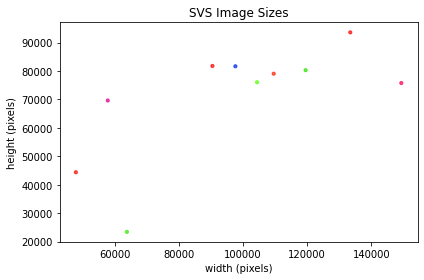

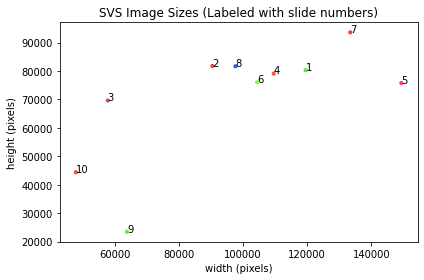

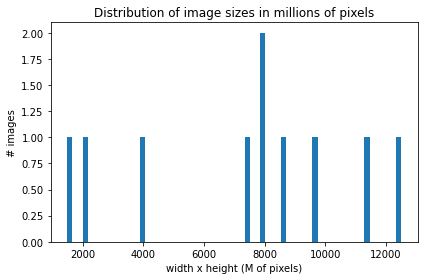

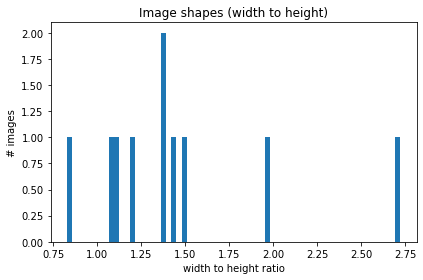

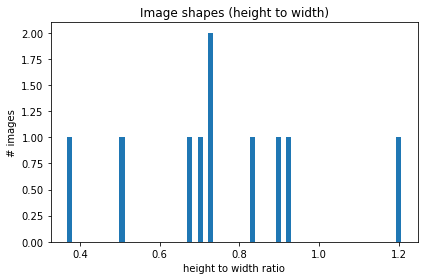

In [29]:
slide.slide_stats()

In [30]:
filter_.multiprocess_apply_filters_to_images()

Applying filters to images (multiprocess)

Processing slide #8
Processing slide #1
Processing slide #3
Processing slide #6
Number of processes: 4
Number of training images: 10
Task #1: Process slides 1 to 2
Task #2: Process slides 3 to 5
Task #3: Process slides 6 to 7
Task #4: Process slides 8 to 10
RGB                  | Time: 0:00:00.714879  Type: uint8   Shape: (2176, 1805, 3)
RGB                  | Time: 0:00:02.171552  Type: uint8   Shape: (2509, 3734, 3)
RGB                  | Time: 0:00:02.262142  Type: uint8   Shape: (2376, 3261, 3)
RGB                  | Time: 0:00:02.326100  Type: uint8   Shape: (2552, 3050, 3)
Save Image           | Time: 0:00:04.598249  Name: ../data/filter_png/TEST-TR-003-001-rgb.png
Save Thumbnail       | Time: 0:00:00.083098  Name: ../data/filter_thumbnail_jpg/TEST-TR-003-001-rgb.jpg
Filter Green Channel | Time: 0:00:00.067078  Type: bool    Shape: (2176, 1805)
Mask RGB             | Time: 0:00:00.038871  Type: uint8   Shape: (2176, 1805, 3)
Save Image  

Save Image           | Time: 0:00:14.817851  Name: ../data/filter_png/TEST-TR-004-001-rgb.png
Save Thumbnail       | Time: 0:00:00.273151  Name: ../data/filter_thumbnail_jpg/TEST-TR-004-001-rgb.jpg
Filter Green Channel | Time: 0:00:00.131256  Type: bool    Shape: (2470, 3423)
Filter Blue Pen      | Time: 0:00:02.553869  Type: bool    Shape: (2509, 3734)
Mask RGB             | Time: 0:00:00.166568  Type: uint8   Shape: (2509, 3734, 3)
Mask RGB             | Time: 0:00:00.251346  Type: uint8   Shape: (2470, 3423, 3)
Save Image           | Time: 0:00:13.032679  Name: ../data/filter_png/TEST-TR-006-005-rgb-no-green-pen.png
Save Thumbnail       | Time: 0:00:00.284867  Name: ../data/filter_thumbnail_jpg/TEST-TR-006-005-rgb-no-green-pen.jpg
Save Image           | Time: 0:00:16.551394  Name: ../data/filter_png/TEST-TR-008-004-rgb-no-red-pen.png
Save Thumbnail       | Time: 0:00:00.194875  Name: ../data/filter_thumbnail_jpg/TEST-TR-008-004-rgb-no-red-pen.jpg
Filter Blue Pen      | Time: 0:00:01

Mask RGB             | Time: 0:00:00.120560  Type: uint8   Shape: (2470, 3423, 3)
Save Image           | Time: 0:00:09.803910  Name: ../data/filter_png/TEST-TR-002-003-rgb-not-gray.png
Save Thumbnail       | Time: 0:00:00.151533  Name: ../data/filter_thumbnail_jpg/TEST-TR-002-003-rgb-not-gray.jpg
Filter Red Pen       | Time: 0:00:01.083820  Type: bool    Shape: (2555, 2826)
Mask RGB             | Time: 0:00:00.166631  Type: uint8   Shape: (2555, 2826, 3)
Save Image           | Time: 0:00:13.131786  Name: ../data/filter_png/TEST-TR-007-002-rgb-not-green.png
Save Thumbnail       | Time: 0:00:00.320205  Name: ../data/filter_thumbnail_jpg/TEST-TR-007-002-rgb-not-green.jpg
Save Image           | Time: 0:00:09.575862  Name: ../data/filter_png/TEST-TR-004-007-rgb-no-gray-no-green-no-pens.png
Save Thumbnail       | Time: 0:00:00.220905  Name: ../data/filter_thumbnail_jpg/TEST-TR-004-007-rgb-no-gray-no-green-no-pens.jpg
Save Image           | Time: 0:00:12.614948  Name: ../data/filter_png/TEST-

Filter Green Channel | Time: 0:00:00.017637  Type: bool    Shape: (1387, 1493)
Filter Green Channel | Time: 0:00:00.039489  Type: bool    Shape: (1387, 1493)
Filter Green Channel | Time: 0:00:00.106878  Type: bool    Shape: (1387, 1493)
Mask RGB             | Time: 0:00:00.080117  Type: uint8   Shape: (1387, 1493, 3)
Filter Red Pen       | Time: 0:00:02.146887  Type: bool    Shape: (2925, 4170)
Mask RGB             | Time: 0:00:00.261007  Type: uint8   Shape: (2925, 4170, 3)
Save Image           | Time: 0:00:02.129727  Name: ../data/filter_png/TEST-TR-010-002-rgb-not-green.png
Save Thumbnail       | Time: 0:00:00.071195  Name: ../data/filter_thumbnail_jpg/TEST-TR-010-002-rgb-not-green.jpg
Filter Grays         | Time: 0:00:00.193549  Type: bool    Shape: (1387, 1493)
Mask RGB             | Time: 0:00:00.121170  Type: uint8   Shape: (1387, 1493, 3)
Save Image           | Time: 0:00:01.346438  Name: ../data/filter_png/TEST-TR-010-003-rgb-not-gray.png
Save Thumbnail       | Time: 0:00:00.0

Save Image           | Time: 0:00:08.651571  Name: ../data/filter_png/TEST-TR-007-007-rgb-no-gray-no-green-no-pens.png
Mask RGB             | Time: 0:00:00.277304  Type: uint8   Shape: (2367, 4668, 3)
Save Thumbnail       | Time: 0:00:00.493609  Name: ../data/filter_thumbnail_jpg/TEST-TR-007-007-rgb-no-gray-no-green-no-pens.jpg
Remove Small Objs    | Time: 0:00:01.381584  Type: bool    Shape: (2925, 4170)
Mask RGB             | Time: 0:00:00.203672  Type: uint8   Shape: (2925, 4170, 3)
Save Image           | Time: 0:00:08.351704  Name: ../data/filter_png/TEST-TR-005-006-rgb-no-blue-pen.png
Save Thumbnail       | Time: 0:00:00.259632  Name: ../data/filter_thumbnail_jpg/TEST-TR-005-006-rgb-no-blue-pen.jpg
Mask RGB             | Time: 0:00:00.339682  Type: uint8   Shape: (2367, 4668, 3)
Save Image           | Time: 0:00:09.549892  Name: ../data/filter_png/TEST-TR-007-008-rgb-not-green-not-gray-no-pens-remove-small.png
Save Thumbnail       | Time: 0:00:00.342568  Name: ../data/filter_thumb

In [33]:
tiles.summary_and_tiles(1, display=True, save_summary=True, save_data=False, save_top_tiles=False)

RGB                  | Time: 0:00:00.381653  Type: uint8   Shape: (2509, 3734, 3)
RGB                  | Time: 0:00:00.590474  Type: uint8   Shape: (2509, 3734, 3)
Save Tile Sum        | Time: 0:00:02.746273  Name: ../data/tile_summary_png/TEST-TR-001-32x-119519x80300-3734x2509-tile_summary.png
Save Tile Sum Thumb  | Time: 0:00:00.066064  Name: ../data/tile_summary_thumbnail_jpg/TEST-TR-001-32x-119519x80300-3734x2509-tile_summary.jpg
Save Tile Sum Orig   | Time: 0:00:03.847895  Name: ../data/tile_summary_on_original_png/TEST-TR-001-32x-119519x80300-3734x2509-tile_summary.png
Save Tile Sum Orig T | Time: 0:00:00.076641  Name: ../data/tile_summary_on_original_thumbnail_jpg/TEST-TR-001-32x-119519x80300-3734x2509-tile_summary.jpg
RGB                  | Time: 0:00:00.773172  Type: uint8   Shape: (2509, 3734, 3)
RGB                  | Time: 0:00:00.068322  Type: uint8   Shape: (2828, 3744, 3)
RGB                  | Time: 0:00:00.001653  Type: uint8   Shape: (820, 490, 3)
RGB                 

In [34]:
tiles.multiprocess_filtered_images_to_tiles()

Generating tile summaries (multiprocess)

Number of processes: 4
Number of training images: 10
Task #1: Process slides 1 to 2
Task #2: Process slides 3 to 5
Task #3: Process slides 6 to 7
Task #4: Process slides 8 to 10
RGB                  | Time: 0:00:00.320786  Type: uint8   Shape: (2176, 1805, 3)
RGB                  | Time: 0:00:00.614582  Type: uint8   Shape: (2509, 3734, 3)
RGB                  | Time: 0:00:00.665628  Type: uint8   Shape: (2376, 3261, 3)
RGB                  | Time: 0:00:00.696837  Type: uint8   Shape: (2552, 3050, 3)
Save Tile Data       | Time: 0:00:00.035345  Name: ../data/tile_data/TEST-TR-003-32x-57768x69640-1805x2176-tile_data.csv
RGB                  | Time: 0:00:00.283865  Type: uint8   Shape: (2176, 1805, 3)
Save Tile Sum        | Time: 0:00:01.732614  Name: ../data/tile_summary_png/TEST-TR-003-32x-57768x69640-1805x2176-tile_summary.png
Save Tile Sum Thumb  | Time: 0:00:00.084378  Name: ../data/tile_summary_thumbnail_jpg/TEST-TR-003-32x-57768x69640-1805

Save Tile            | Time: 0:00:01.673824  Name: ../data/tiles_png/003/TEST-TR-003-tile-r34-c10-x9217-y33796-w1024-h1024.png
Save Top Tiles Image | Time: 0:00:10.772960  Name: ../data/top_tile_summary_png/TEST-TR-008-32x-97607x81671-3050x2552-top_tile_summary.png
Save Top Tiles Thumb | Time: 0:00:00.195866  Name: ../data/top_tile_summary_thumbnail_jpg/TEST-TR-008-32x-97607x81671-3050x2552-top_tile_summary.jpg
Save Tile            | Time: 0:00:01.708024  Name: ../data/tiles_png/003/TEST-TR-003-tile-r32-c10-x9217-y31748-w1024-h1024.png
Save Tile            | Time: 0:00:01.754713  Name: ../data/tiles_png/003/TEST-TR-003-tile-r32-c8-x7169-y31748-w1024-h1024.png
Save Top Orig        | Time: 0:00:10.088874  Name: ../data/top_tile_summary_on_original_png/TEST-TR-006-32x-104377x76058-3261x2376-top_tile_summary.png
Save Top Orig Thumb  | Time: 0:00:00.144652  Name: ../data/top_tile_summary_on_original_thumbnail_jpg/TEST-TR-006-32x-104377x76058-3261x2376-top_tile_summary.jpg
Save Tile         

Save Tile            | Time: 0:00:01.645977  Name: ../data/tiles_png/001/TEST-TR-001-tile-r20-c20-x19461-y19459-w1024-h1024.png
Save Tile            | Time: 0:00:01.490307  Name: ../data/tiles_png/003/TEST-TR-003-tile-r30-c11-x10241-y29699-w1024-h1024.png
Save Tile            | Time: 0:00:01.772873  Name: ../data/tiles_png/006/TEST-TR-006-tile-r57-c15-x14339-y57364-w1024-h1024.png
Save Tile            | Time: 0:00:01.855583  Name: ../data/tiles_png/008/TEST-TR-008-tile-r20-c15-x14337-y19458-w1024-h1024.png
Save Tile            | Time: 0:00:01.806169  Name: ../data/tiles_png/001/TEST-TR-001-tile-r24-c26-x25607-y23556-w1024-h1024.png
Save Tile            | Time: 0:00:01.682667  Name: ../data/tiles_png/003/TEST-TR-003-tile-r27-c11-x10241-y26627-w1024-h1024.png
Save Tile            | Time: 0:00:01.958678  Name: ../data/tiles_png/006/TEST-TR-006-tile-r31-c40-x39946-y30731-w1024-h1024.png
Save Tile            | Time: 0:00:01.574527  Name: ../data/tiles_png/008/TEST-TR-008-tile-r29-c24-x23554

Save Tile            | Time: 0:00:02.281999  Name: ../data/tiles_png/008/TEST-TR-008-tile-r27-c25-x24578-y26626-w1024-h1024.png
Save Tile            | Time: 0:00:02.226649  Name: ../data/tiles_png/001/TEST-TR-001-tile-r8-c63-x63504-y7169-w1024-h1024.png
Save Tile            | Time: 0:00:01.945974  Name: ../data/tiles_png/006/TEST-TR-006-tile-r17-c17-x16388-y16390-w1024-h1024.png
Save Tile            | Time: 0:00:01.803653  Name: ../data/tiles_png/001/TEST-TR-001-tile-r24-c24-x23558-y23556-w1024-h1024.png
Save Tile            | Time: 0:00:01.633715  Name: ../data/tiles_png/008/TEST-TR-008-tile-r30-c25-x24578-y29699-w1024-h1024.png
Save Tile            | Time: 0:00:01.818252  Name: ../data/tiles_png/006/TEST-TR-006-tile-r53-c31-x30727-y53266-w1024-h1024.png
Save Tile            | Time: 0:00:01.690585  Name: ../data/tiles_png/001/TEST-TR-001-tile-r23-c24-x23558-y22531-w1024-h1024.png
Save Tile            | Time: 0:00:02.869312  Name: ../data/tiles_png/008/TEST-TR-008-tile-r60-c90-x91143-y

Save Tile Sum Orig   | Time: 0:00:09.606303  Name: ../data/tile_summary_on_original_png/TEST-TR-004-32x-109560x79070-3423x2470-tile_summary.png
Save Tile Sum Orig T | Time: 0:00:00.236270  Name: ../data/tile_summary_on_original_thumbnail_jpg/TEST-TR-004-32x-109560x79070-3423x2470-tile_summary.jpg
Save Tile            | Time: 0:00:01.860987  Name: ../data/tiles_png/008/TEST-TR-008-tile-r18-c25-x24578-y17409-w1024-h1024.png
RGB                  | Time: 0:00:01.763314  Type: uint8   Shape: (2470, 3423, 3)
Save Tile            | Time: 0:00:01.646728  Name: ../data/tiles_png/008/TEST-TR-008-tile-r17-c15-x14337-y16385-w1024-h1024.png
RGB                  | Time: 0:00:00.093426  Type: uint8   Shape: (2796, 3424, 3)
Save Tile            | Time: 0:00:01.698660  Name: ../data/tiles_png/008/TEST-TR-008-tile-r16-c19-x18433-y15361-w1024-h1024.png
RGB                  | Time: 0:00:00.002659  Type: uint8   Shape: (820, 490, 3)
RGB                  | Time: 0:00:00.219877  Type: uint8   Shape: (2796, 3

Save Tile            | Time: 0:00:01.998281  Name: ../data/tiles_png/004/TEST-TR-004-tile-r66-c67-x67599-y66585-w1024-h1024.png
Save Tile            | Time: 0:00:01.844952  Name: ../data/tiles_png/009/TEST-TR-009-tile-r10-c50-x50200-y9225-w1024-h1024.png
Save Top Tiles Image | Time: 0:00:07.674583  Name: ../data/top_tile_summary_png/TEST-TR-002-32x-90439x81789-2826x2555-top_tile_summary.png
Save Tile            | Time: 0:00:02.049861  Name: ../data/tiles_png/004/TEST-TR-004-tile-r69-c53-x53260-y69658-w1024-h1024.png
Save Tile            | Time: 0:00:01.846947  Name: ../data/tiles_png/009/TEST-TR-009-tile-r6-c51-x51225-y5125-w1024-h1024.png
Save Top Tiles Thumb | Time: 0:00:00.257049  Name: ../data/top_tile_summary_thumbnail_jpg/TEST-TR-002-32x-90439x81789-2826x2555-top_tile_summary.jpg
Save Tile            | Time: 0:00:01.524134  Name: ../data/tiles_png/009/TEST-TR-009-tile-r9-c6-x5122-y8200-w1024-h1024.png
Save Tile            | Time: 0:00:02.180328  Name: ../data/tiles_png/004/TEST-T

Save Tile            | Time: 0:00:01.817027  Name: ../data/tiles_png/002/TEST-TR-002-tile-r30-c36-x35843-y29707-w1024-h1024.png
Save Tile            | Time: 0:00:02.703025  Name: ../data/tiles_png/004/TEST-TR-004-tile-r73-c50-x50187-y73756-w1024-h1024.png
Save Top Orig        | Time: 0:00:14.963548  Name: ../data/top_tile_summary_on_original_png/TEST-TR-007-32x-133463x93602-4170x2925-top_tile_summary.png
Save Tile            | Time: 0:00:01.269247  Name: ../data/tiles_png/009/TEST-TR-009-tile-r6-c7-x6147-y5125-w1024-h1024.png
Save Top Orig Thumb  | Time: 0:00:00.248760  Name: ../data/top_tile_summary_on_original_thumbnail_jpg/TEST-TR-007-32x-133463x93602-4170x2925-top_tile_summary.jpg
Save Tile            | Time: 0:00:01.813458  Name: ../data/tiles_png/002/TEST-TR-002-tile-r25-c70-x70661-y24585-w1024-h1024.png
Save Tile            | Time: 0:00:02.297612  Name: ../data/tiles_png/004/TEST-TR-004-tile-r69-c55-x55308-y69658-w1024-h1024.png
Save Tile            | Time: 0:00:01.445911  Name:

Save Tile            | Time: 0:00:02.012141  Name: ../data/tiles_png/004/TEST-TR-004-tile-r68-c53-x53260-y68634-w1024-h1024.png
Save Tile            | Time: 0:00:01.870575  Name: ../data/tiles_png/002/TEST-TR-002-tile-r35-c63-x63493-y34828-w1024-h1024.png
Save Tile            | Time: 0:00:01.653249  Name: ../data/tiles_png/007/TEST-TR-007-tile-r59-c87-x88079-y59393-w1024-h1024.png
Save Tile            | Time: 0:00:02.220051  Name: ../data/tiles_png/004/TEST-TR-004-tile-r72-c65-x65550-y72732-w1024-h1024.png
Save Tile            | Time: 0:00:01.697021  Name: ../data/tiles_png/002/TEST-TR-002-tile-r26-c36-x35843-y25609-w1024-h1024.png
Save Tile            | Time: 0:00:01.642545  Name: ../data/tiles_png/007/TEST-TR-007-tile-r57-c67-x67596-y57345-w1024-h1024.png
Save Tile Data       | Time: 0:00:00.047472  Name: ../data/tile_data/TEST-TR-010-32x-47807x44395-1493x1387-tile_data.csv
RGB                  | Time: 0:00:00.341182  Type: uint8   Shape: (1387, 1493, 3)
Save Tile            | Time: 

Save Tile            | Time: 0:00:02.615940  Name: ../data/tiles_png/010/TEST-TR-010-tile-r11-c35-x34839-y10243-w1024-h1024.png
Save Tile            | Time: 0:00:01.776051  Name: ../data/tiles_png/002/TEST-TR-002-tile-r28-c37-x36867-y27658-w1024-h1024.png
Save Tile            | Time: 0:00:01.683957  Name: ../data/tiles_png/007/TEST-TR-007-tile-r20-c9-x8193-y19456-w1024-h1024.png
Save Tile            | Time: 0:00:01.878262  Name: ../data/tiles_png/002/TEST-TR-002-tile-r31-c26-x25602-y30731-w1024-h1024.png
Save Tile            | Time: 0:00:02.925783  Name: ../data/tiles_png/010/TEST-TR-010-tile-r12-c33-x32789-y11267-w1024-h1024.png
Save Tile            | Time: 0:00:01.560715  Name: ../data/tiles_png/007/TEST-TR-007-tile-r23-c47-x47112-y22528-w1024-h1024.png
Save Tile            | Time: 0:00:01.843924  Name: ../data/tiles_png/002/TEST-TR-002-tile-r41-c73-x73734-y40975-w1024-h1024.png
Save Tile            | Time: 0:00:01.632898  Name: ../data/tiles_png/007/TEST-TR-007-tile-r58-c49-x49160-y

Save Tile            | Time: 0:00:00.945984  Name: ../data/tiles_png/010/TEST-TR-010-tile-r17-c23-x22543-y16388-w1024-h1024.png
Save Tile            | Time: 0:00:00.607242  Name: ../data/tiles_png/005/TEST-TR-005-tile-r36-c93-x94223-y35854-w1024-h1024.png
Save Tile            | Time: 0:00:00.605143  Name: ../data/tiles_png/005/TEST-TR-005-tile-r27-c9-x8193-y26634-w1024-h1024.png
Save Tile            | Time: 0:00:00.997438  Name: ../data/tiles_png/010/TEST-TR-010-tile-r13-c34-x33814-y12291-w1024-h1024.png
Save Tile            | Time: 0:00:00.608778  Name: ../data/tiles_png/005/TEST-TR-005-tile-r40-c93-x94223-y39951-w1024-h1024.png
Save Tile            | Time: 0:00:00.620394  Name: ../data/tiles_png/005/TEST-TR-005-tile-r28-c9-x8193-y27659-w1024-h1024.png
Save Tile            | Time: 0:00:01.044222  Name: ../data/tiles_png/010/TEST-TR-010-tile-r11-c31-x30740-y10243-w1024-h1024.png
Save Tile            | Time: 0:00:00.558507  Name: ../data/tiles_png/005/TEST-TR-005-tile-r22-c8-x7169-y2151

Save Tile            | Time: 0:00:00.606520  Name: ../data/tiles_png/005/TEST-TR-005-tile-r31-c9-x8193-y30732-w1024-h1024.png
Done tiling slides: [3, 4, 5]
Done tiling slides: [6, 7]
Done tiling slides: [8, 9, 10]
Time to generate tile previews (multiprocess): 0:07:40.018938

